# Sentiment Analysis on Movie Reviews 


## Sofia Vaca Angulo: Mini proyect + TP track 

In this notebook, I aim to improve sentiment classification accuracy with state-of-the art models (embedding or LLMs). 

The data used can be find here: https://ai.stanford.edu/~amaas/data/sentiment/ which was produced by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011). 


In [174]:
import os
# Base path
base_path = "C:/Users/sofia/OneDrive/Documentos/8. Master/M2/ML for NLP/aclImdb"

In [4]:
import os
import pandas as pd

# Define a function to load text files and assign sentiment labels
def load_imdb_data(folder_path):
    """
    Loads IMDB reviews from a given folder (train or test),
    returning a pandas DataFrame with two columns: 'text' and 'label'.
    Label = 1 for positive, 0 for negative.
    """
    data = {"text": [], "label": []}
    
    for sentiment in ["pos", "neg"]:
        sentiment_path = os.path.join(folder_path, sentiment)
        label = 1 if sentiment == "pos" else 0
        
        for filename in os.listdir(sentiment_path):
            file_path = os.path.join(sentiment_path, filename)
            with open(file_path, "r", encoding="utf-8") as f:
                data["text"].append(f.read())
                data["label"].append(label)
    
    return pd.DataFrame(data)


# Load training and test data
train_df = load_imdb_data(os.path.join(base_path, "train"))
test_df = load_imdb_data(os.path.join(base_path, "test"))

# Preview the data
print(train_df.head())


                                                text  label
0  Bromwell High is a cartoon comedy. It ran at t...      1
1  Homelessness (or Houselessness as George Carli...      1
2  Brilliant over-acting by Lesley Ann Warren. Be...      1
3  This is easily the most underrated film inn th...      1
4  This is not the typical Mel Brooks film. It wa...      1


# Data

In [ ]:
def describe_dataset(df, name="Dataset"):
    print(f"\n=== {name} ===")
    print(f"Number of samples: {len(df)}")
    
    class_counts = df["label"].value_counts().sort_index()
    class_percentages = class_counts / len(df) * 100

    summary = pd.DataFrame({
        "Sentiment": ["Negative", "Positive"],
        "Count": class_counts.values,
        "Percentage": class_percentages.values
    })
    print("\nClass distribution:")
    print(summary)
    
    df["char_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    
    print("\nCharacter length summary:")
    print(df["char_length"].describe())
    
    print("\nWord count summary:")
    print(df["word_count"].describe())

# Apply to both datasets
describe_dataset(train_df, name="Training Set")
describe_dataset(test_df, name="Test Set")


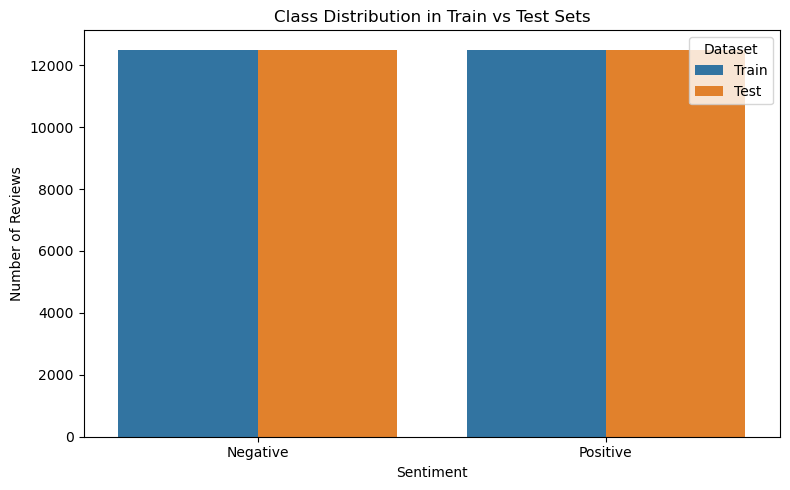

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a summary DataFrame for plotting
train_counts = train_df["label"].value_counts().sort_index()
test_counts = test_df["label"].value_counts().sort_index()

summary_df = pd.DataFrame({
    "Sentiment": ["Negative", "Positive"],
    "Train": train_counts.values,
    "Test": test_counts.values
})

# Convert to long format for seaborn
plot_df = pd.melt(summary_df, id_vars="Sentiment", var_name="Set", value_name="Count")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x="Sentiment", y="Count", hue="Set")
plt.title("Class Distribution in Train vs Test Sets")
plt.ylabel("Number of Reviews")
plt.xlabel("Sentiment")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


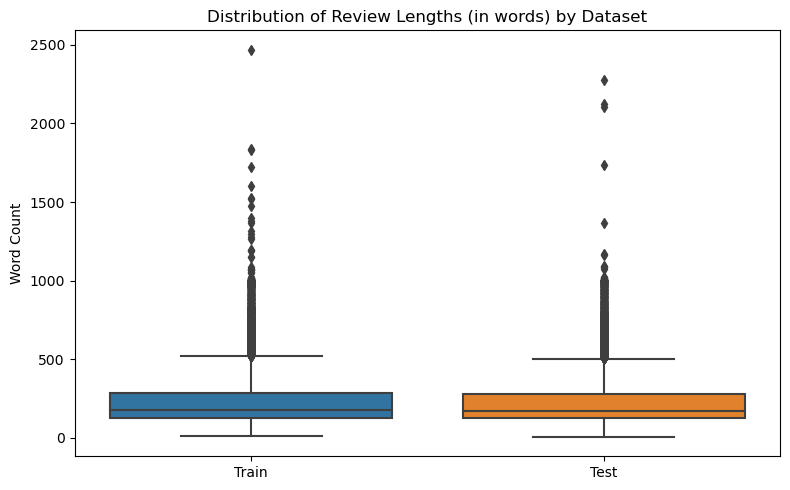

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df["word_count"] = train_df["text"].apply(lambda x: len(x.split()))
test_df["word_count"] = test_df["text"].apply(lambda x: len(x.split()))

train_df["Set"] = "Train"
test_df["Set"] = "Test"

combined_df = pd.concat([train_df[["word_count", "Set"]],
                         test_df[["word_count", "Set"]]])

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=combined_df, x="Set", y="word_count")
plt.title("Distribution of Review Lengths (in words) by Dataset")
plt.ylabel("Word Count")
plt.xlabel("")
plt.tight_layout()
plt.show()


# Traditional approaches

In [28]:
#Import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

## Preporcessing data

In [168]:
# Preprocessing the data
def preprocess_traditional_models(text):
    """
    Preprocessing in the spirit of the Maas et al. (2011) paper:
    - Remove HTML tags like <br />
    - Keep punctuation (e.g., !, :) which can convey sentiment
    - Do NOT remove stopwords
    - Do NOT apply stemming or lemmatization
    - Do NOT lowercase 
    """
    # Replace <br /> HTML tags with space
    text = re.sub(r"<br\s*/?>", " ", text)

    # Optionally normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply this preprocessing to both train and test sets
train_df['text_preprocessed'] = train_df['text'].apply(preprocess_traditional_models)
test_df['text_preprocessed'] = test_df['text'].apply(preprocess_traditional_models)

## Bag of words + SVM Classifier + TF-IDF 

Accuracy: 0.8714

Classification Report (SVM):

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     12500
    Positive       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



<Figure size 600x400 with 0 Axes>

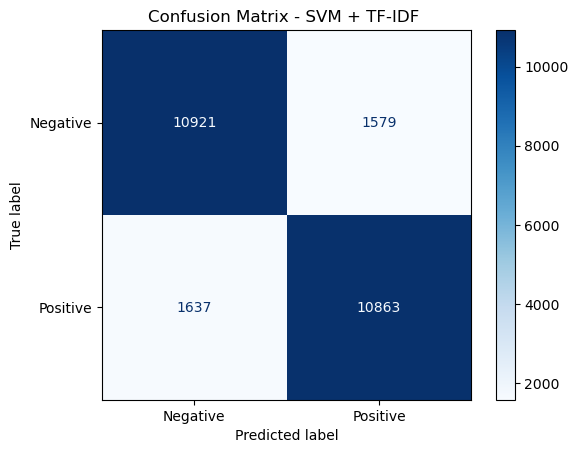

In [172]:
# Create the vectorizer (no stopword removal)
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 1),
    stop_words=None
)

# Fit on training data and transform both train/test sets
X_train = vectorizer.fit_transform(train_df['text_preprocessed'])
X_test = vectorizer.transform(test_df['text_preprocessed'])

# Labels
y_train = train_df['label']
y_test = test_df['label']

# Train a linear SVM (Support Vector Classifier)
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm_model.predict(X_test)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report (SVM):\n")
print(classification_report(y_test, y_pred_svm, target_names=["Negative", "Positive"]))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot the matrix
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM + TF-IDF ")
plt.show()

## Bag of Words  + Logistic Regression + Delta-IDF

Accuracy: 0.8834

Classification Report (Delta-IDF + Logistic Regression):

              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



<Figure size 600x400 with 0 Axes>

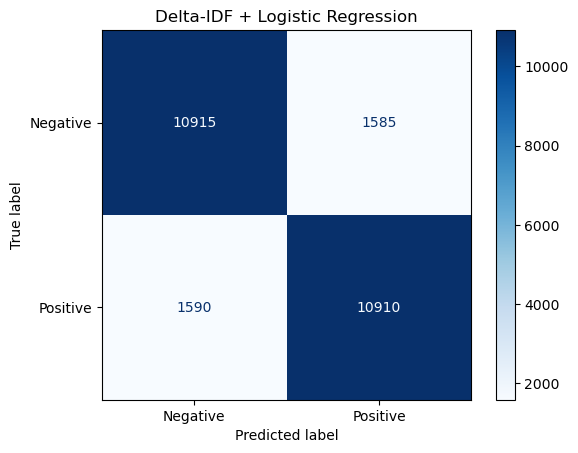

In [176]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Vectorize using Bag of Words
vectorizer = CountVectorizer(max_features=5000, stop_words=None)
X_train_counts = vectorizer.fit_transform(train_df['text_preprocessed'])
X_test_counts = vectorizer.transform(test_df['text_preprocessed'])

# Get vocabulary and reverse index
vocab = vectorizer.get_feature_names_out()
vocab_size = len(vocab)

# Get class labels
y_train = np.array(train_df['label'])  # 0 = negative, 1 = positive
y_test = np.array(test_df['label'])

# Compute document frequency per class
# Boolean matrix: 1 if word appears in doc, 0 otherwise
X_train_binary = (X_train_counts > 0).astype(int)

# Document frequencies for each class
df_pos = np.array(X_train_binary[y_train == 1].sum(axis=0)).flatten()
df_neg = np.array(X_train_binary[y_train == 0].sum(axis=0)).flatten()

# Avoid division by zero
df_pos[df_pos == 0] = 1
df_neg[df_neg == 0] = 1

# Compute Delta-IDF manually
delta_idf = np.log(df_pos / df_neg)

# Apply Delta-IDF as feature weights
X_train_weighted = X_train_counts.multiply(delta_idf)
X_test_weighted = X_test_counts.multiply(delta_idf)

# Train Logistic Regression on weighted features
model = LogisticRegression(max_iter=1000)
model.fit(X_train_weighted, y_train)

# Evaluate
y_pred_delta = model.predict(X_test_weighted)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report (Delta-IDF + Logistic Regression):\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_delta)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot the matrix
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues")
plt.title("Delta-IDF + Logistic Regression")
plt.show()

##  LSA (Latent Semantic Analysis) + SVM

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

In [57]:
# TF-IDF without stopword removal
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None)

# Transform the text (use Maas-style preprocessed text)
X_train_tfidf = vectorizer.fit_transform(train_df['text_preprocessed'])
X_test_tfidf = vectorizer.transform(test_df['text_preprocessed'])

y_train = train_df['label']
y_test = test_df['label']

# Reduce dimensionality using SVD (LSA step)
lsa = TruncatedSVD(n_components=100, random_state=42)

# Apply LSA to TF-IDF vectors
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

# Train a linear SVM on the LSA features
svm_lsa = LinearSVC()
svm_lsa.fit(X_train_lsa, y_train)

# Predict and evaluate
y_pred_lsa = svm_lsa.predict(X_test_lsa)

print(f"Accuracy: {accuracy_score(y_test, y_pred_lsa):.4f}")
print("\nClassification Report (LSA + SVM):\n")
print(classification_report(y_test, y_pred_lsa, target_names=["Negative", "Positive"]))


Accuracy: 0.8470

Classification Report (LSA + SVM):

              precision    recall  f1-score   support

    Negative       0.85      0.84      0.85     12500
    Positive       0.84      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



## Latent Dirichlet Allocation (LDA) + SVM

In [60]:
# Sample smaller subsets to speed up LDA
train_sample = train_df.sample(n=5000, random_state=42).reset_index(drop=True)
test_sample = test_df.sample(n=5000, random_state=42).reset_index(drop=True)

# Convert text to bag-of-words representation
vectorizer = CountVectorizer(max_features=5000, stop_words=None)
X_train_counts = vectorizer.fit_transform(train_sample['text_preprocessed'])
X_test_counts = vectorizer.transform(test_sample['text_preprocessed'])

# Train LDA on training set with fewer topics
lda = LatentDirichletAllocation(n_components=20, random_state=42)
X_train_lda = lda.fit_transform(X_train_counts)
X_test_lda = lda.transform(X_test_counts)

# Train SVM classifier using topic distributions
svm_lda = LinearSVC()
svm_lda.fit(X_train_lda, train_sample['label'])

# Predict and evaluate
y_pred_lda = svm_lda.predict(X_test_lda)
print(f"Accuracy: {accuracy_score(test_sample['label'], y_pred_lda):.4f}")
print("\nClassification Report (LDA + SVM):\n")
print(classification_report(test_sample['label'], y_pred_lda, target_names=["Negative", "Positive"]))

Accuracy: 0.7250

Classification Report (LDA + SVM, fast version):

              precision    recall  f1-score   support

    Negative       0.69      0.80      0.74      2484
    Positive       0.77      0.65      0.70      2516

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.72      5000
weighted avg       0.73      0.72      0.72      5000



## Word2Vec + SVM

In [159]:
#pip install gensim


In [62]:
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


In [64]:
# Tokenize the text into words (lists of words)
train_sentences = train_df['text_preprocessed'].apply(str.split).tolist()
test_sentences = test_df['text_preprocessed'].apply(str.split).tolist()

# Train a Word2Vec model on training data
w2v_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=5, workers=4)

# Average Word2Vec embedding for each document
def document_vector(doc, model):
    """Averages word vectors for a document if words are in the vocabulary"""
    vectors = [model.wv[word] for word in doc if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in train_sentences])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in test_sentences])

y_train = train_df['label'].values
y_test = test_df['label'].values

# Train SVM on document vectors
svm_model = LinearSVC(max_iter=5000)
svm_model.fit(X_train_w2v, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test_w2v)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report (Word2Vec + SVM):\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


Accuracy: 0.7843

Classification Report (Word2Vec + SVM):

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.78     12500
    Positive       0.78      0.79      0.79     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000



## LLM for Sentiment Analysis

In [151]:
#pip install langchain

In [144]:
import os
os.environ["GROQ_API_KEY"] = "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"

from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [145]:
from pydantic import BaseModel
from pydantic import BaseModel, Field

class Sentiment(BaseModel):
    sentiment: int = Field(description="""The sentiment of the movie review, 0 for negative, 1 for positive""")

from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template("""
You are a sentiment analysis expert. 
You will be given a movie review and must classify its sentiment as:

- 0 → for a **negative** review  
- 1 → for a **positive** review

Only return the number `0` or `1`. 
Do not include any explanation, punctuation, or other text.

Respond only with a JSON object like this: {{ "sentiment": 0 }}

Review:
{review}
""")

In [146]:
chain = prompt | llm.with_structured_output(Sentiment)

In [147]:
from tqdm import tqdm
import time

predictions = []

# Number of reviews to process 
n_rows = 400

# Create a clean subset for the LLM
llm_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True).iloc[:n_rows].copy()


# Check how balanced the first n_rows are in terms of sentiment labels
subset_labels = llm_df["label"].iloc[:n_rows].value_counts().sort_index()

# Create a summary table with counts and percentages
balance_summary = pd.DataFrame({
    "Sentiment": ["Negative", "Positive"],
    "Count": [subset_labels[0], subset_labels[1]],
    "Percentage": [subset_labels[0] / n_rows * 100, subset_labels[1] / n_rows * 100]
})

print("\nLabel distribution in the LLM evaluation subset:")
print(balance_summary)

# Analyze sentiment using LLM

start_time = time.time()
for review in tqdm(llm_df["text"], desc="Analyzing Sentiment"):
    response = chain.invoke({"review": review})
    sentiment = response.sentiment
    predictions.append(sentiment)

end_time = time.time()

# Assign predictions to new column
llm_df["llm_predictions"] = predictions

# Print total processing time
elapsed = end_time - start_time
print(f"\nElapsed time: {elapsed:.2f} seconds")


Label distribution in the LLM evaluation subset:
  Sentiment  Count  Percentage
0  Negative    186        46.5
1  Positive    214        53.5


Analyzing Sentiment: 100%|██████████| 400/400 [42:06<00:00,  6.32s/it] 


Elapsed time: 2526.41 seconds


In [148]:
valid_rows = llm_df[llm_df["llm_predictions"].isin([0, 1])].copy()
print(f"Valid predictions: {len(valid_rows)} / {len(llm_df)}")


Valid predictions: 400 / 400


In [155]:
# Make sure predictions are in 0/1 format and that there are no unexpected values from the LLM 
llm_df["llm_predictions"] = llm_df["llm_predictions"].replace(-1, 0)
llm_df[["text", "label", "llm_predictions"]].head(10)


,text,label,llm_predictions
0,Very interesting to find another reviewer who ...,0,0
1,Although Casper van Dien and Michael Rooker ar...,0,0
2,Rent this only movie if you're in the mood for...,0,0
3,A brief history of time. The cosmological cont...,1,0
4,"This is the ultimate, and I mean the ULTIMATE,...",1,1
5,this film is what happens when people see like...,0,0
6,SPOILERS<br /><br />This movie was rented as a...,0,0
7,Anyone who gives this movie less than 8 needs ...,1,1
8,Fans of Gerry Anderson's productions will reco...,1,1
9,This is a great horror movie. Great Plot. And ...,1,1


In [156]:
print(llm_df["llm_predictions"].value_counts())

0    200
1    200
Name: llm_predictions, dtype: int64


LLM Accuracy: 0.9400

Classification Report (LLM):
              precision    recall  f1-score   support

    Negative       0.91      0.97      0.94       186
    Positive       0.97      0.91      0.94       214

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



<Figure size 600x400 with 0 Axes>

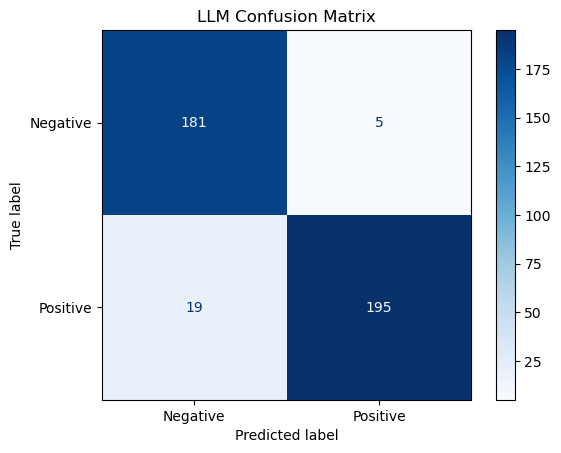

In [157]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract true and predicted labels
y_true = llm_df["label"]
y_pred = llm_df["llm_predictions"]

# Accuracy and classification report
print(f"LLM Accuracy: {accuracy_score(y_true, y_pred):.4f}\n")
print("Classification Report (LLM):")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues")
plt.title("LLM Confusion Matrix")
plt.show()
